# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**.

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [94]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [95]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

In [126]:
# How many rows and columns does the dataset contain?
data.shape

(5391, 6)

In [127]:
# Are there any NaN values present?
data.isna().sum()

,0
Rank,0
Release_Date,0
Movie_Title,0
USD_Production_Budget,0
USD_Worldwide_Gross,0
USD_Domestic_Gross,0


In [128]:
# Are there any duplicate rows?
data.duplicated().sum()

np.int64(0)

In [129]:
# What are the data types of the columns?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Data Type Conversions

Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`.
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [100]:
chars_to_remove = [',', '$']
columns_to_clean = ['USD_Production_Budget',
                    'USD_Worldwide_Gross',
                    'USD_Domestic_Gross']

for col in columns_to_clean:
    for char in chars_to_remove:
        # Replace each character with an empty string
        data[col] = data[col].astype(str).str.replace(char, "")
    # Convert column to a numeric data type
    data[col] = pd.to_numeric(data[col])

Convert the `Release_Date` column to a Pandas Datetime type.

In [101]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [102]:
data.describe()

,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27"


The average film costs about \$31m to make and makes around 3x that (or ~\$89m) in worldwide revenue. So that's encouraging.

But quite a lot of films lose money too. In fact, all the films in the bottom quartile lose money, since the average cost is \$5 million and they only bring in \$3.8m in worldwide revenue!

The minimum domestic and worldwide revenue is \$0. That makes sense. If a film never gets screened or is cancelled, then this is the number we would expect to see here.

On the other hand, the highest production budget was \$425,000,000 and the highest worldwide revenue was \$2,783,918,982. \$2.7 Billion revenue!

In [103]:
highest_budget_movie = data.loc[data['USD_Production_Budget'].idxmax()]
print(f"The movie with the highest budget is: {highest_budget_movie['Movie_Title']} with a budget of ${highest_budget_movie['USD_Production_Budget']:,} and a worldwide gross revenue of ${highest_budget_movie['USD_Worldwide_Gross']:,}")


The movie with the highest budget is: Avatar with a budget of $425,000,000 and a worldwide gross revenue of $2,783,918,982


In [104]:
lowest_budget_movie = data.loc[data['USD_Production_Budget'].idxmin()]
print(f"The movie with the highest budget is: {lowest_budget_movie['Movie_Title']} with a budget of ${lowest_budget_movie['USD_Production_Budget']:,} and a worldwide gross revenue of ${lowest_budget_movie['USD_Worldwide_Gross']:,}")

The movie with the highest budget is: My Date With Drew with a budget of $1,100 and a worldwide gross revenue of $181,041


# Investigating the Zero Revenue Films

How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [105]:
data.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000


In [106]:
data[data['USD_Domestic_Gross']==0].sort_values(by='USD_Production_Budget', ascending=False)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


We see that there are 512 films in the dataset that had no revenue in the United States. However, the highest budget films with no revenue have a release date AFTER the date on which the dataset was compiled (May 1st, 2018).

How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [107]:
data[data['USD_Worldwide_Gross']==0].sort_values(by='USD_Production_Budget', ascending=False)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


When we check worldwide revenue instead, we see that there are 357 films that made no money internationally. Once again, some of the films have not been released yet at the time the data was compiled. However, 512 versus 357. Why is there a difference?

The reason some international films were never screened in the United States.  In fact, we can see an example of this in our previous screenshot. "Don Gato, el inicio de la pandilla" made about \$4.5 million dollars in the box office, but nothing in the United States. Perhaps they should have screened it there too, considering it cost $80 million to make!

### Filtering on Multiple Conditions

In [108]:
international_releases = data.loc[
    (data['USD_Domestic_Gross'] == 0) & (data['USD_Worldwide_Gross'] != 0)
]
print(f"Number of international releases: {len(international_releases)}")
international_releases.head()

Number of international releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States.

In [109]:
data.query('USD_Worldwide_Gross != 0 and USD_Domestic_Gross == 0')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Unreleased Films

In [110]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [111]:
# Identify which films were not released yet as of the time of data collection (May 1st, 2018).
future_releases = data[data['Release_Date'] > scrape_date]
print(f"Number of films not yet released: {len(future_releases)}")
future_releases

Number of films not yet released: 7


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5386,2950,2018-10-08,Meg,15000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5388,96,2020-12-31,Singularity,175000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0


In [112]:
# Create another DataFrame called data_clean that does not include these films.
data_clean = data.drop(future_releases.index)

### Films that Lost Money

What is the percentage of films where the production costs exceeded the worldwide gross revenue?

In [113]:
data_clean['profit'] = data_clean['USD_Worldwide_Gross'] - data_clean['USD_Production_Budget']
print(f"Percentage of files where the production costs exceeded the worldwide gross revenue: {round(len(data_clean[data_clean['profit'] < 0])/len(data_clean)*100,2)}%")
data_clean[data_clean['profit'] < 0]

Percentage of files where the production costs exceeded the worldwide gross revenue: 37.28%


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,profit
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
6,4630,1927-12-08,Wings,2000000,0,0,-2000000
8,4240,1930-01-01,Hell's Angels,4000000,0,0,-4000000
15,4738,1936-05-02,Modern Times,1500000,165049,163245,-1334951
17,4814,1936-10-20,"Charge of the Light Brigade, The",1200000,0,0,-1200000
...,...,...,...,...,...,...,...
5371,4901,2017-07-28,An Inconvenient Sequel,1000000,130874,130874,-869126
5373,2161,2017-08-25,Tulip Fever,25000000,0,0,-25000000
5374,4237,2017-08-25,Polina danser sa vie,4000000,36630,0,-3963370
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,-34987392


# Seaborn for Data Viz: Bubble Charts

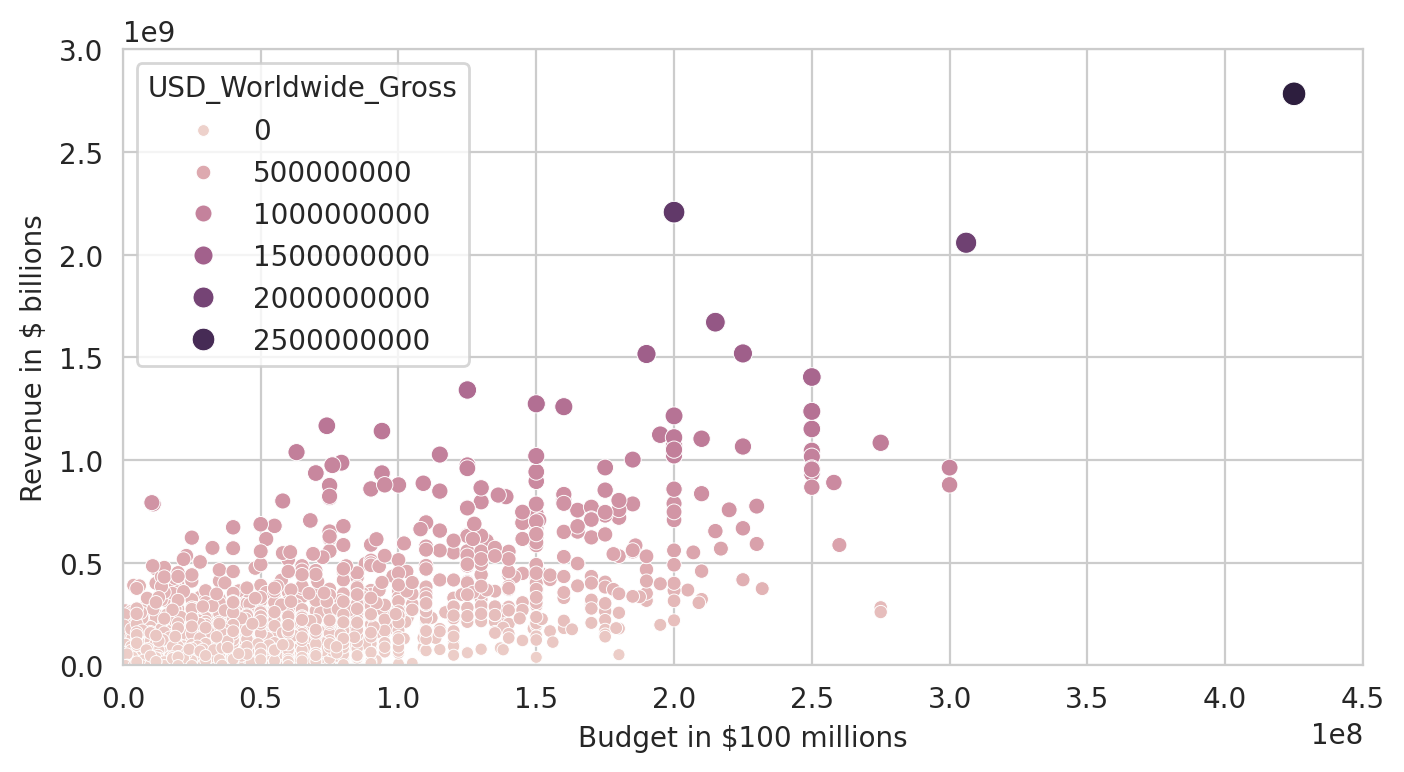

In [114]:
plt.figure(figsize=(8,4), dpi=200)

# set styling on a single chart
with sns.axes_style('whitegrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='USD_Production_Budget',
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')

  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time



In [115]:
data_clean.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,profit
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,21755000


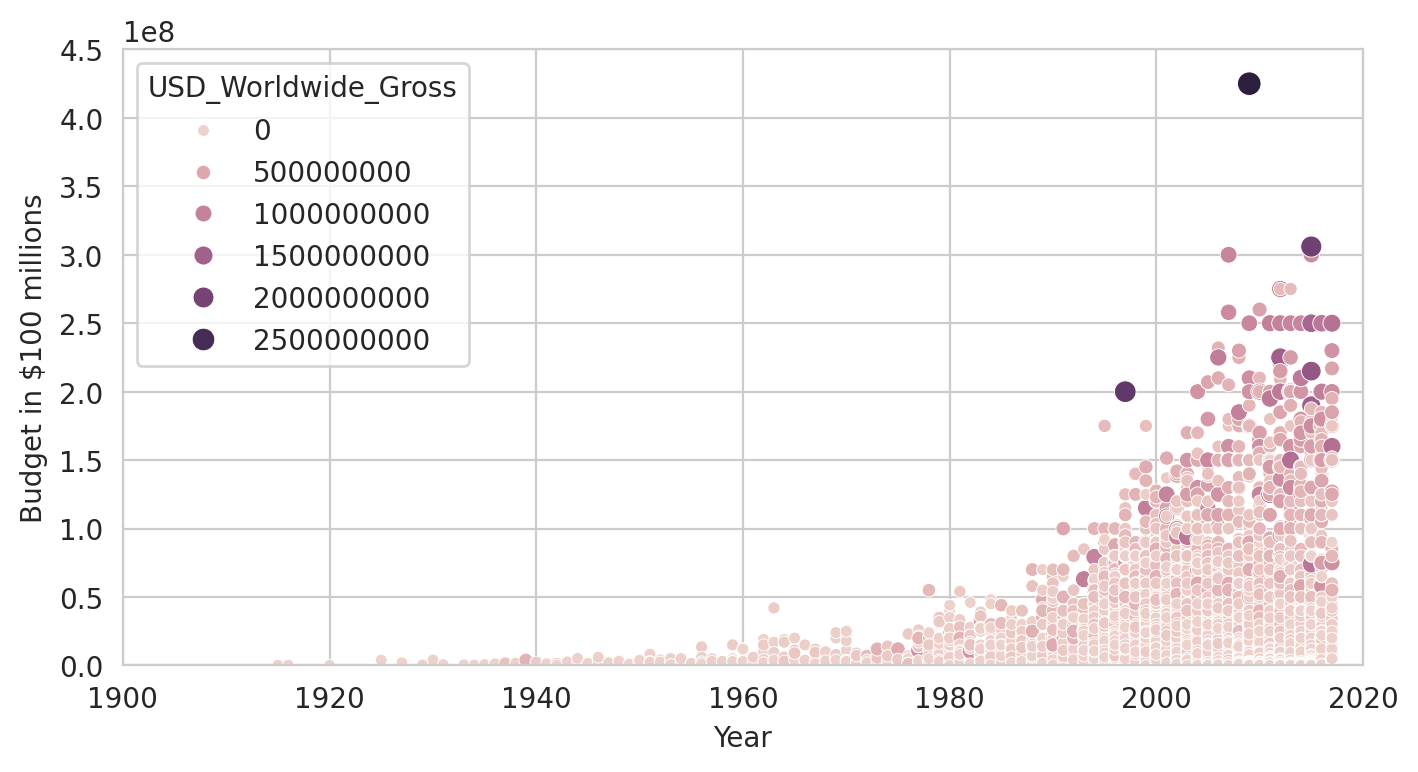

In [116]:
plt.figure(figsize=(8,4), dpi=200)
data_clean['Release_Year'] = data_clean['Release_Date'].dt.year

# set styling on a single chart
with sns.axes_style('whitegrid'):
  ax = sns.scatterplot(data=data_clean,
                       y='USD_Production_Budget',
                       x='Release_Year',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')

  ax.set(ylim=(0, 450000000),
        xlim=(1900, 2020),
        ylabel='Budget in $100 millions',
        xlabel='Year')

Well, first off, movie budgets have just exploded in the last 40 years or so. Up until the 1970s, the film industry appears to have been in an entirely different era. Budgets started growing fast from the 1980s onwards and continued to grow through the 2000s. Also, the industry has grown massively, producing many more films than before. The number of data points is so dense from 2000 onwards that they are overlapping.

# Converting Years to Decades Trick

Create a column in `data_clean` that has the decade of the release.

In [117]:
data_clean['Decade'] = data_clean['Release_Year'] // 10 * 10
data_clean.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,profit,Release_Year,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000,1915,1910
1,5140,1916-05-09,Intolerance,385907,0,0,-385907,1916,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000,1916,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000,1920,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,21755000,1925,1920


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

In [118]:
old_films = data_clean[data_clean['Release_Year'] <= 1969]
most_expensive_old_film = old_films.loc[old_films['USD_Production_Budget'].idxmax()]
print(f"Number of films released prior to 1970: {len(old_films)}")
print(f"The most expensive film made prior to 1970 was {most_expensive_old_film['Movie_Title']} with a budget of ${most_expensive_old_film['USD_Production_Budget']:,}")
old_films.head()

Number of films released prior to 1970: 153
The most expensive film made prior to 1970 was Cleopatra with a budget of $42,000,000


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,profit,Release_Year,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000,1915,1910
1,5140,1916-05-09,Intolerance,385907,0,0,-385907,1916,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000,1916,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000,1920,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,21755000,1925,1920


The most expensive film prior to 1970 was Cleopatra, with a production budget of $42 million. That's some serious 1960s money, and judging by the trailer, a lot of it went into extravagant costumes, set design, and plenty of extras. Impressive.

In [119]:
new_films = data_clean[data_clean['Release_Year'] > 1969]
print(f"Number of films released since 1970: {len(new_films)}")
new_films.head()

Number of films released since 1970: 5231


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,profit,Release_Year,Decade
153,2159,1970-01-01,Waterloo,25000000,0,0,-25000000,1970,1970
154,2270,1970-01-01,Darling Lili,22000000,5000000,5000000,-17000000,1970,1970
155,3136,1970-01-01,Patton,12000000,62500000,62500000,50500000,1970,1970
156,3277,1970-01-01,The Molly Maguires,11000000,2200000,2200000,-8800000,1970,1970
157,4265,1970-01-01,M*A*S*H,3500000,81600000,81600000,78100000,1970,1970


# Seaborn Regression Plots

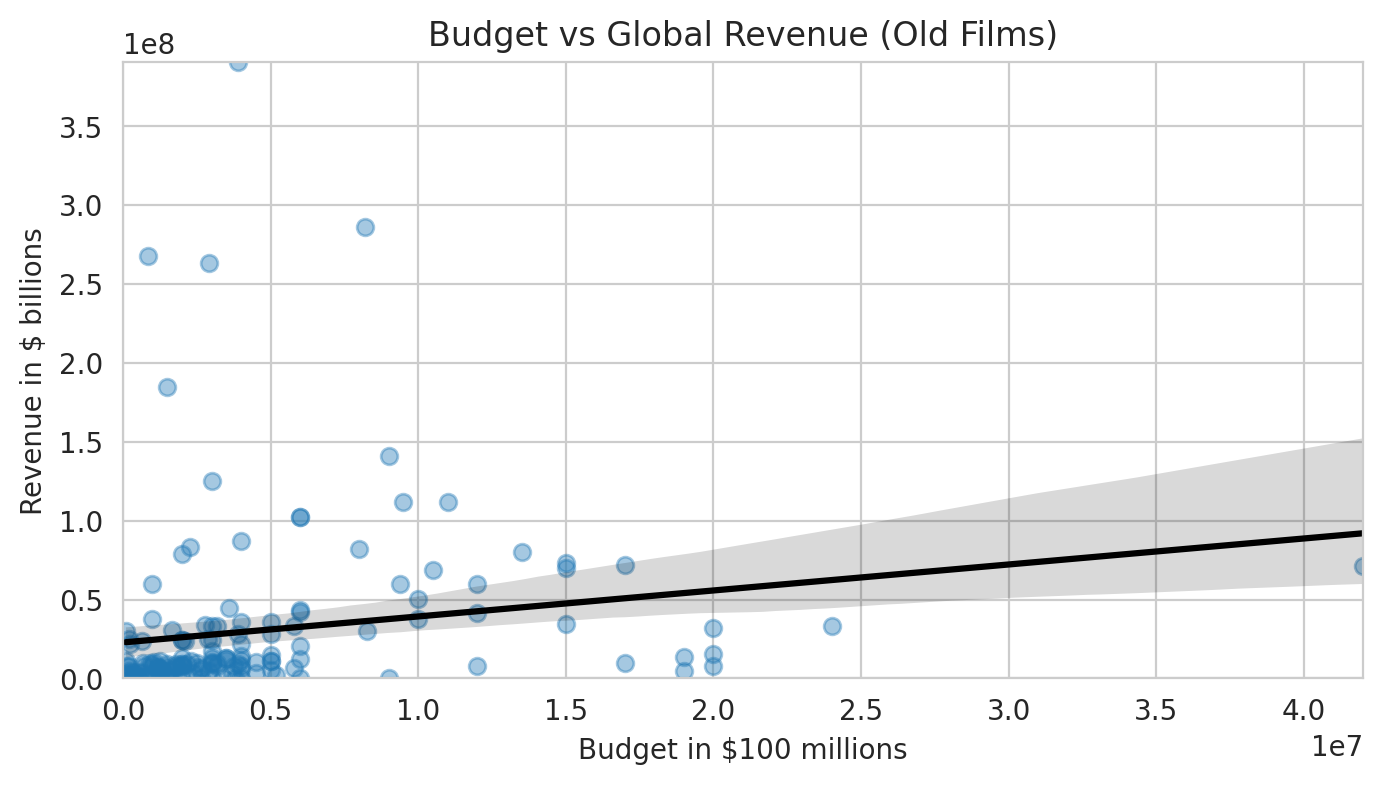

In [120]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
    ax = sns.regplot(
        data=old_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        scatter_kws={'alpha': 0.4},
        line_kws={'color': 'black'}
    )
    ax.set(
        ylim=(0, old_films['USD_Worldwide_Gross'].max()),
        xlim=(0, old_films['USD_Production_Budget'].max()),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions'
    )

plt.title('Budget vs Global Revenue (Old Films)')
plt.show()

Well, first off we can spot Cleopatra on the far right. But also, we see that many lower budget films made much more money! The relationship between the production budget and movie revenue is not very strong. Many points on the left are very far away for the line, so the line appears not to capture the relationship between budget and revenue very well at all!

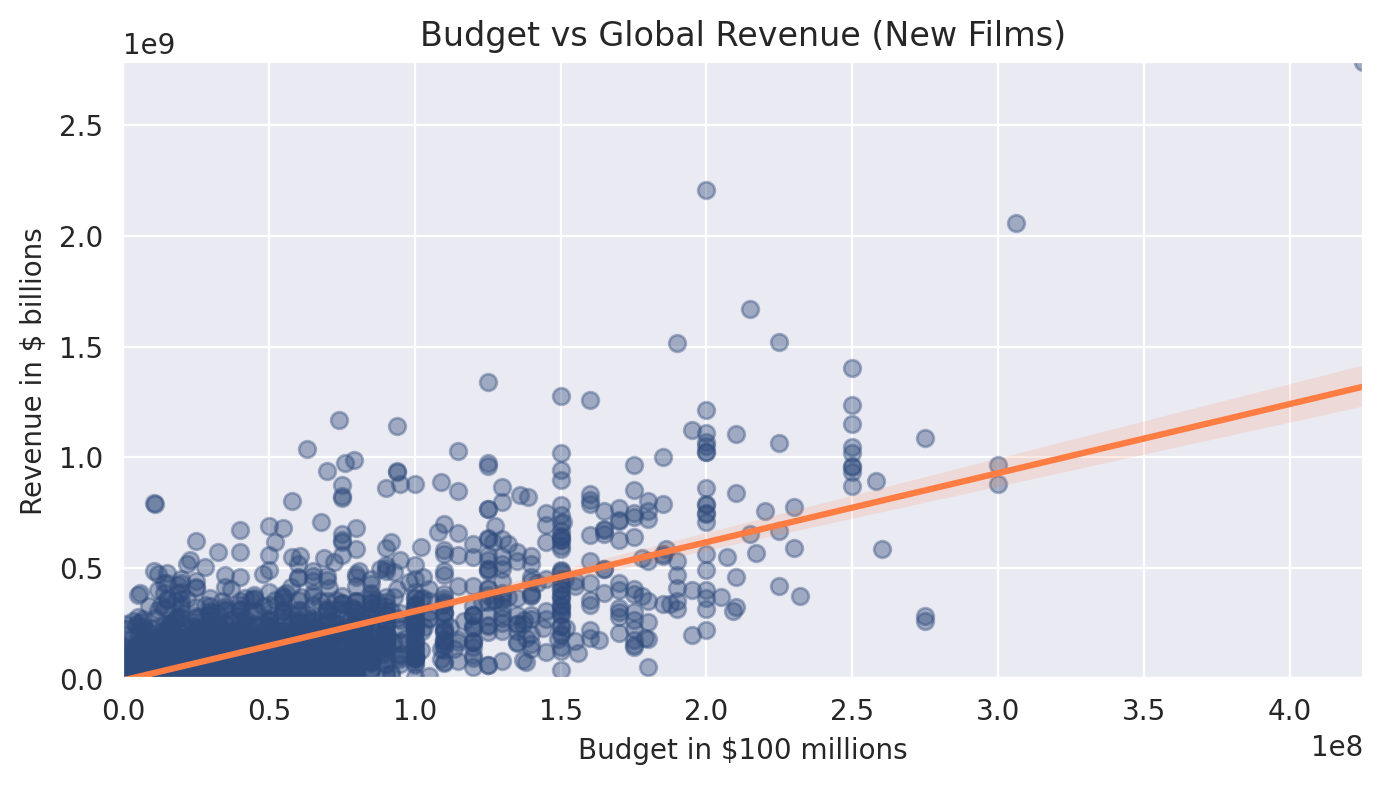

In [121]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("darkgrid"):
    ax = sns.regplot(
        data=new_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        scatter_kws={'alpha': 0.4, 'color': '#2f4b7c'},
        line_kws={'color': '#ff7c43'}
    )
    ax.set(
        ylim=(0, new_films['USD_Worldwide_Gross'].max()),
        xlim=(0, new_films['USD_Production_Budget'].max()),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions'
    )

plt.title('Budget vs Global Revenue (New Films)')
plt.show()

This time we are getting a much better fit, compared to the old films. We can see this visually from the fact that our data points line up much better with our regression line (pun intended). Also, the confidence interval is much narrower. We also see that a film with a \$150 million budget is predicted to make slightly under $500 million by our regression line.
All in all, we can be pretty confident that there does indeed seem to be a relationship between a film's budget and that film's worldwide revenue.

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [122]:
regression_new = LinearRegression()

# Explanatory Variable(s) or Feature(s)
X_new = pd.DataFrame(new_films, columns=['USD_Production_Budget'])

# Response Variable or Target
y_new = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])

regression_new.fit(X_new, y_new)

print(f"Intercept: {regression_new.intercept_}")
print(f"Coefficient: {regression_new.coef_}")
print(f"R-squared: {regression_new.score(X_new, y_new)}")

Intercept: [-8650768.00661027]
Coefficient: [[3.12259592]]
R-squared: 0.5577032617720403


The y-intercept means that if a movie budget is \$0, the estimated movie revenue is -$8.65 million. Hmm... so this is clearly unrealistic. Why would our model tell us such nonsense? Well, the reason is that we are specifying what the model should be ahead of time - namely a straight line - and then finding the best straight line for our data. Considering that you can't have negative revenue or a negative budget, we have to be careful about interpreting our very simple model too literally. After all, it's just an estimate and this estimate will be the most accurate on the chart where we have the most data points (rather than at the extreme left or right).

The slope tells us that for every extra \$1 in the budget, movie revenue increases by $3.1. So, that's pretty interesting. That means the higher our budget, the higher our estimated revenue. If budgets are all that matter to make lots of money, then studio executives and film financiers should try and produce the biggest films possible, right? Maybe that's exactly why we've seen a massive increase in budgets over the past 30 years.

We see that our r-squared comes in at around 0.558. This means that our model explains about 56% of the variance in movie revenue. That's actually pretty amazing, considering we've got the simplest possible model, with only one explanatory variable. The real world is super complex, so in many academic circles, if a researcher can build a simple model that explains over 50% or so of what is actually happening, then it's a pretty decent model.

In [123]:
regression_old = LinearRegression()

# Explanatory Variable(s) or Feature(s)
X_old = pd.DataFrame(old_films, columns=['USD_Production_Budget'])

# Response Variable or Target
y_old = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

regression_old.fit(X_old, y_old)

print(f"Intercept: {regression_old.intercept_}")
print(f"Coefficient: {regression_old.coef_}")
print(f"R-squared: {regression_old.score(X_old, y_old)}")

Intercept: [22821538.63508039]
Coefficient: [[1.64771314]]
R-squared: 0.02937258620576877


Running the numbers this time around, we can confirm just how inappropriate the linear model is for the pre-1970 films. We still see a positive relationship between budgets and revenue, since the slope (our theta-one) is 1.6, but the r-squared is very low.

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [125]:
budget = 350000000
revenue_estimate = regression_new.intercept_[0] + regression_new.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 million film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 million film is around $1.084e+09.
